In [1]:
# 📦 Imports y Configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42


---

## 2. El Problema de la Varianza

### Un árbol solo es "inestable"
Pequeños cambios en el dataset producen árboles **completamente diferentes**.

C:\Users\Theki\AppData\Local\Temp\ipykernel_45448\3472235763.py:36: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Theki\AppData\Local\Temp\ipykernel_45448\3472235763.py:36: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


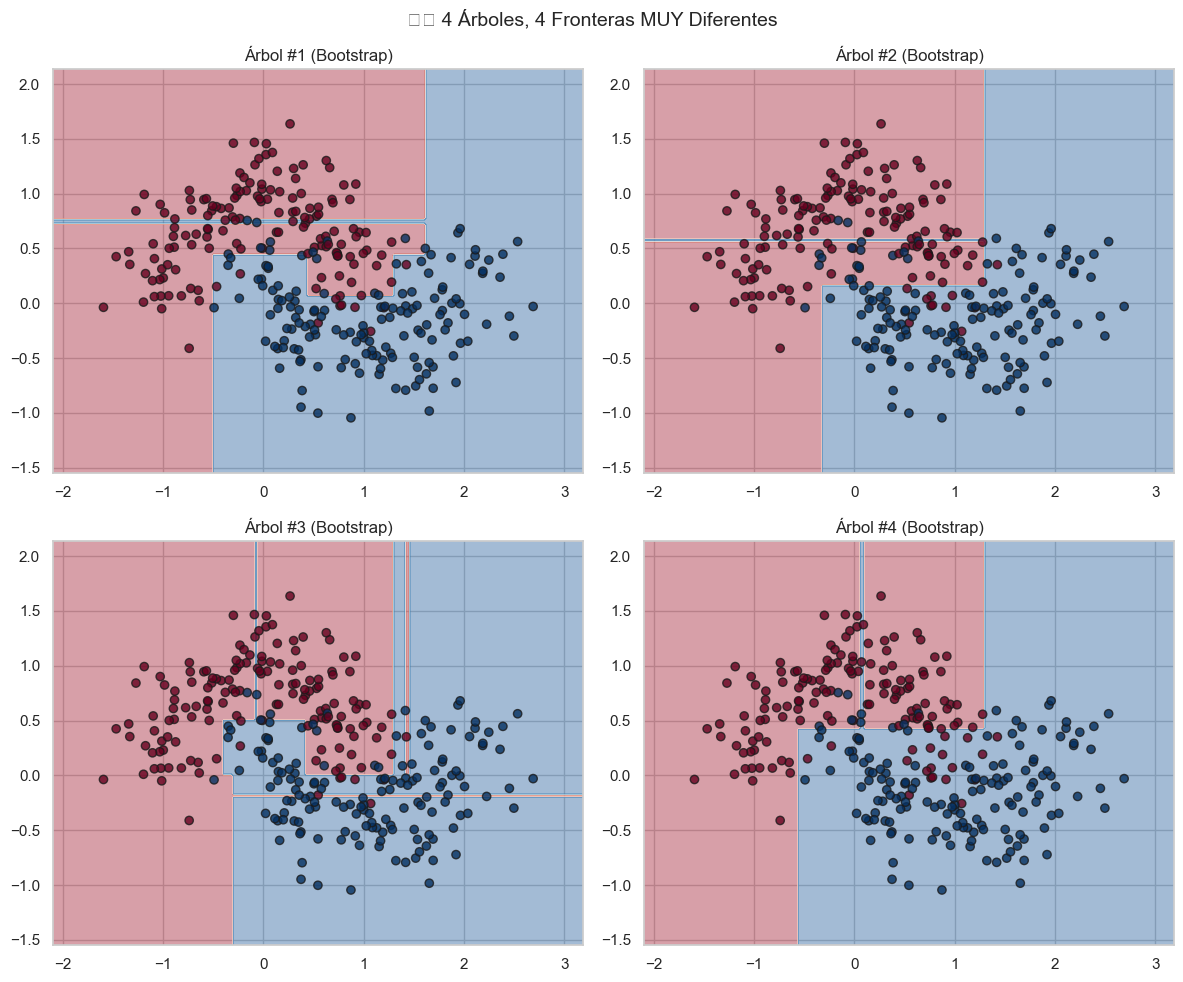

🔍 Observa: Cada árbol captura patrones diferentes.
   Si promediamos sus predicciones, el 'ruido' se cancela.


In [2]:
# Generar datos base
X, y = make_moons(n_samples=300, noise=0.25, random_state=RANDOM_STATE)

# Función para visualizar frontera


def plot_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.8)
    ax.set_title(title)


# Entrenar 4 árboles en 4 subconjuntos diferentes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    # Muestreo bootstrap
    idx = np.random.choice(len(X), size=len(X), replace=True)
    X_boot, y_boot = X[idx], y[idx]

    tree = DecisionTreeClassifier(max_depth=5, random_state=i)
    tree.fit(X_boot, y_boot)

    plot_decision_boundary(tree, X, y, ax, f'Árbol #{i+1} (Bootstrap)')

plt.suptitle('⚠️ 4 Árboles, 4 Fronteras MUY Diferentes', fontsize=14)
plt.tight_layout()
plt.show()

print("🔍 Observa: Cada árbol captura patrones diferentes.")
print("   Si promediamos sus predicciones, el 'ruido' se cancela.")


---

## 3. La Magia del Bagging

### Bootstrap Aggregating (Bagging)

```
Para cada árbol t = 1, 2, ..., T:
    1. Muestrear N ejemplos CON reemplazo (bootstrap)
    2. Entrenar árbol en ese subconjunto
    3. En cada split, usar √p features aleatorios

Predicción final = VOTACIÓN mayoritaria (clasificación)
                   PROMEDIO (regresión)
```

### 📐 ¿Por Qué Funciona?

| Concepto | Explicación |
|----------|-------------|
| **Diversidad** | Cada árbol ve datos y features diferentes |
| **Decorrelación** | Los errores de cada árbol son independientes |
| **Reducción Varianza** | $\sigma^2_{promedio} = \frac{\sigma^2}{n}$ |

> **💡 Analogía:** Es como preguntar direcciones a 100 personas aleatorias. Algunas se equivocarán, pero el promedio te llevará al destino.

---

## 4. Random Forest en Acción

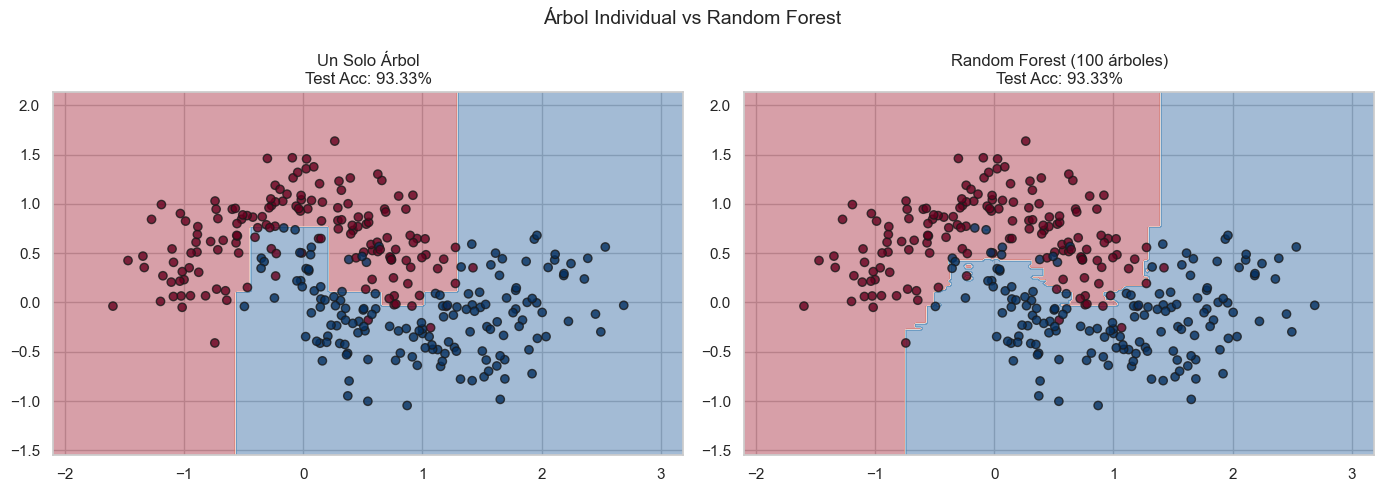

In [3]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE)

# Entrenar Random Forest
rf = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# Entrenar árbol simple para comparación
tree_simple = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
tree_simple.fit(X_train, y_train)

# Comparar fronteras
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_decision_boundary(tree_simple, X, y, axes[0],
                       f'Un Solo Árbol\nTest Acc: {tree_simple.score(X_test, y_test):.2%}')

plot_decision_boundary(rf, X, y, axes[1],
                       f'Random Forest (100 árboles)\nTest Acc: {rf.score(X_test, y_test):.2%}')

plt.suptitle('Árbol Individual vs Random Forest', fontsize=14)
plt.tight_layout()
plt.show()


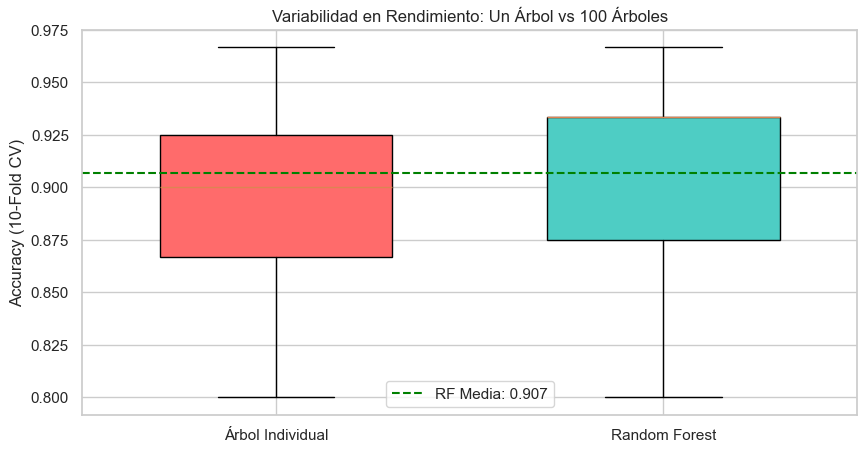

📊 Árbol Individual: 0.890 ± 0.056
📊 Random Forest:    0.907 ± 0.047


In [4]:
# Comparar estabilidad con Cross-Validation
tree_scores = cross_val_score(DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
                              X, y, cv=10)
rf_scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE),
                            X, y, cv=10)

fig, ax = plt.subplots(figsize=(10, 5))
positions = [1, 2]
bp = ax.boxplot([tree_scores, rf_scores], positions=positions,
                widths=0.6, patch_artist=True)

colors = ['#FF6B6B', '#4ECDC4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(positions)
ax.set_xticklabels(['Árbol Individual', 'Random Forest'])
ax.set_ylabel('Accuracy (10-Fold CV)')
ax.set_title('Variabilidad en Rendimiento: Un Árbol vs 100 Árboles')
ax.axhline(y=np.mean(rf_scores), color='green', linestyle='--',
           label=f'RF Media: {np.mean(rf_scores):.3f}')
ax.legend()
plt.show()

print(
    f"📊 Árbol Individual: {np.mean(tree_scores):.3f} ± {np.std(tree_scores):.3f}")
print(
    f"📊 Random Forest:    {np.mean(rf_scores):.3f} ± {np.std(rf_scores):.3f}")


> **💡 Pro-Tip: Estabilidad > Rendimiento Puntual**
> Un modelo que da 85% consistentemente es mejor que uno que da 80%-95% según el día. Random Forest brilla en estabilidad.

---

## 5. Importancia de Variables

Una ventaja de Random Forest: **Feature Importance** basada en cuánto reduce cada variable la impureza.

C:\Users\Theki\AppData\Local\Temp\ipykernel_45448\3743418955.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


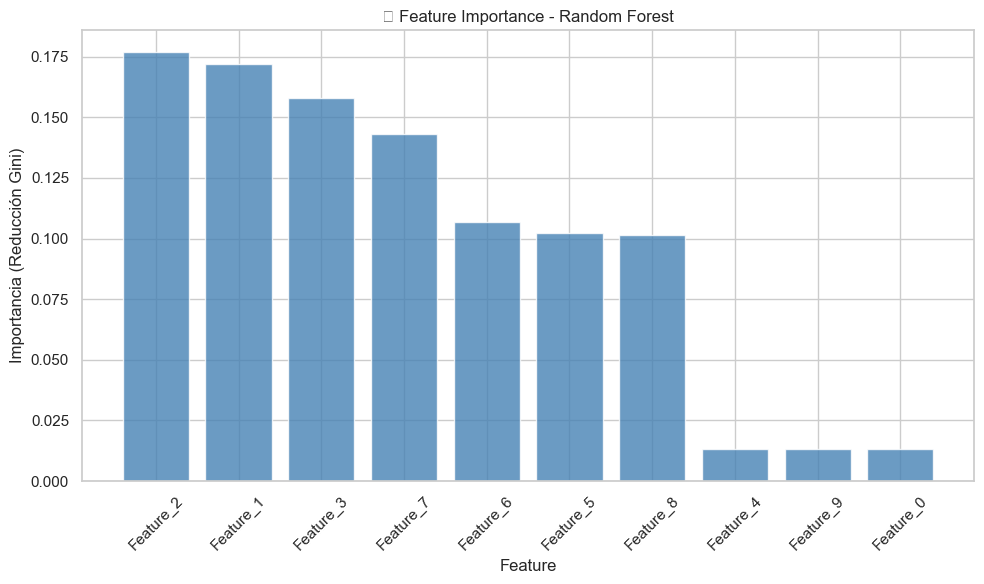

🔍 Las primeras 5 features fueron creadas como 'informativas'.
   El modelo las identifica correctamente como las más importantes.


In [11]:
# Generar datos con más features
from sklearn.datasets import make_classification

X_multi, y_multi = make_classification(
    n_samples=500000, n_features=10, n_informative=5, n_redundant=2,
    n_clusters_per_class=2, random_state=RANDOM_STATE)

feature_names = [f'Feature_{i}' for i in range(10)]

# Entrenar RF
rf_multi = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_multi.fit(X_multi, y_multi)

# Plot importancia
importances = rf_multi.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices], color='steelblue', alpha=0.8)
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importancia (Reducción Gini)')
plt.title('📊 Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

print("🔍 Las primeras 5 features fueron creadas como 'informativas'.")
print("   El modelo las identifica correctamente como las más importantes.")


> **⚠️ Real-World Warning: Correlación ≠ Importancia Causal**
> Feature importance mide asociación predictiva, NO causalidad. Una variable proxy (correlacionada con el target) puede parecer importante aunque no cause el efecto.

---

## 6. Hiperparámetros Clave

| Parámetro | Descripción | Valor Típico |
|-----------|-------------|---------------|
| `n_estimators` | Número de árboles | 100-500 (más = más estable) |
| `max_depth` | Profundidad de cada árbol | 5-15 o None |
| `max_features` | Features por split | `sqrt` (clasificación), `log2` |
| `min_samples_leaf` | Mínimo en hojas | 1-5 |
| `n_jobs` | Paralelización | -1 (todos los cores) |

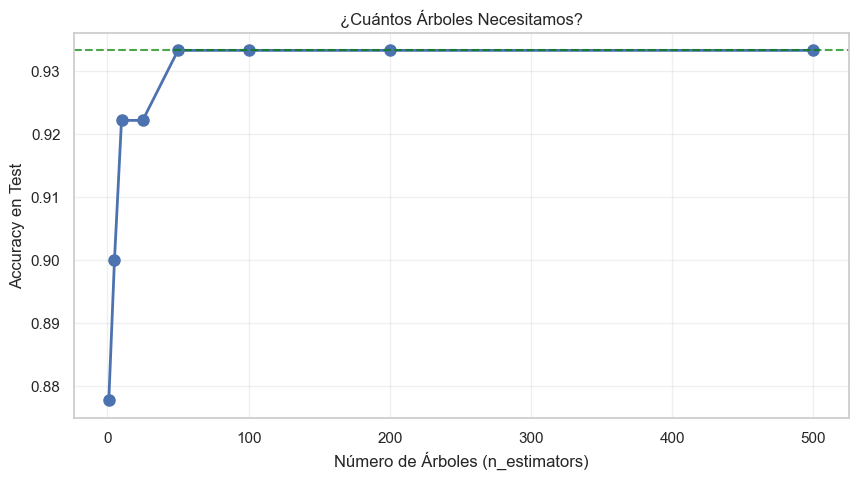

💡 Después de ~100 árboles, las ganancias son marginales.
   Más árboles = más tiempo de entrenamiento.


In [10]:
# Efecto del número de árboles
n_trees_list = [1, 5, 10, 25, 50, 100, 200, 500]
scores = []

X_tr, X_ts, y_tr, y_ts = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE)

for n_trees in n_trees_list:
    rf_temp = RandomForestClassifier(
        n_estimators=n_trees, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1)
    rf_temp.fit(X_tr, y_tr)
    scores.append(rf_temp.score(X_ts, y_ts))

plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Accuracy en Test')
plt.title('¿Cuántos Árboles Necesitamos?')
plt.axhline(y=max(scores), color='green', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Después de ~100 árboles, las ganancias son marginales.")
print("   Más árboles = más tiempo de entrenamiento.")


> **💡 Pro-Tip: La Regla del 100**
> Para la mayoría de problemas, 100 árboles son suficientes. Solo aumenta si tienes datos muy ruidosos o alta dimensionalidad.

---

## 7. Caso de Negocio: Predicción de Churn

Usaremos datos de Telco para predecir qué clientes abandonarán el servicio.

In [12]:
# Cargar datos (asumimos que existe telco_churn.csv)
try:
    df = pd.read_csv('../data/telco_churn.csv',sep=';')
    print(f"✅ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    print("⚠️ Archivo no encontrado. Generando datos sintéticos para demostración...")
    np.random.seed(RANDOM_STATE)
    n = 1000
    df = pd.DataFrame({
        'tenure': np.random.randint(1, 72, n),
        'MonthlyCharges': np.random.uniform(20, 100, n),
        'TotalCharges': np.random.uniform(100, 5000, n),
        'Contract_Month': np.random.binomial(1, 0.5, n),
        'PaymentMethod_Electronic': np.random.binomial(1, 0.4, n),
        'InternetService_Fiber': np.random.binomial(1, 0.35, n),
        'OnlineSecurity_No': np.random.binomial(1, 0.5, n),
        'TechSupport_No': np.random.binomial(1, 0.5, n),
    })
    # Simular Churn basado en features
    prob_churn = 0.1 + 0.3*(df['Contract_Month']) + 0.1 * \
        (df['tenure'] < 12) + 0.15*(df['OnlineSecurity_No'])
    df['Churn'] = (np.random.rand(n) < prob_churn).astype(int)
    print(f"✅ Datos sintéticos generados: {df.shape[0]} filas")

df.head()


✅ Dataset cargado: 19643 filas, 22 columnas


,CodMes,tcsera,TIPO,Geografia,Departamento,Cod_Entidad,Cod_Punto_Venta,Ingresos,Terminal,Color,...,Gama,Precio,Costo_Equipo,prom_llam_201908,prom_llam_201909,prom_llam_201910,prom_llam_201911,prom_llam_201912,Ventana,riesgo_neto_imei
0,201912,1,NO PVAE,LIMA,LIMA,214,1,74.690,BMOBILE TV280,BLANCO,...,GAMA ULTRABAJA,78.0,70.63,0.0,0.0,0.0,0.0,0.0,15,1
1,201912,2,NO PVAE,PROVINCIAS,LAMBAYEQUE,625,1,79.241,BMOBILE AX675,NEGRO,...,GAMA BAJA,NaN,14.03,0.0,0.0,0.0,0.0,0.0,15,1
2,201912,3,NO PVAE,PROVINCIAS,LA LIBERTAD,3557,2,88.951,BMOBILE AX675,NEGRO,...,GAMA BAJA,149.0,14.03,0.0,0.0,0.0,0.0,0.0,15,1
3,201912,4,NO PVAE,PROVINCIAS,ANCASH,5524,17,30.648,BMOBILE AX675,NEGRO,...,GAMA BAJA,150.0,14.03,0.0,0.0,0.0,0.0,0.0,15,1
4,201912,5,NO PVAE,PROVINCIAS,ANCASH,5524,17,30.648,BMOBILE AX675,NEGRO,...,GAMA BAJA,NaN,14.03,0.0,0.0,0.0,0.0,0.0,15,1


In [13]:
# Preparar datos
target = 'Churn' if 'Churn' in df.columns else df.columns[-1]
features = [col for col in df.columns if col !=
            target and df[col].dtype in ['int64', 'float64']]

X_churn = df[features]
y_churn = df[target]

X_tr, X_ts, y_tr, y_ts = train_test_split(X_churn, y_churn, test_size=0.3,
                                          stratify=y_churn, random_state=RANDOM_STATE)

# Entrenar Random Forest
rf_churn = RandomForestClassifier(n_estimators=100, max_depth=6,
                                  min_samples_leaf=10, random_state=RANDOM_STATE)
rf_churn.fit(X_tr, y_tr)

print(f"📊 Accuracy en Test: {rf_churn.score(X_ts, y_ts):.2%}")


📊 Accuracy en Test: 90.84%


C:\Users\Theki\AppData\Local\Temp\ipykernel_45448\666975957.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


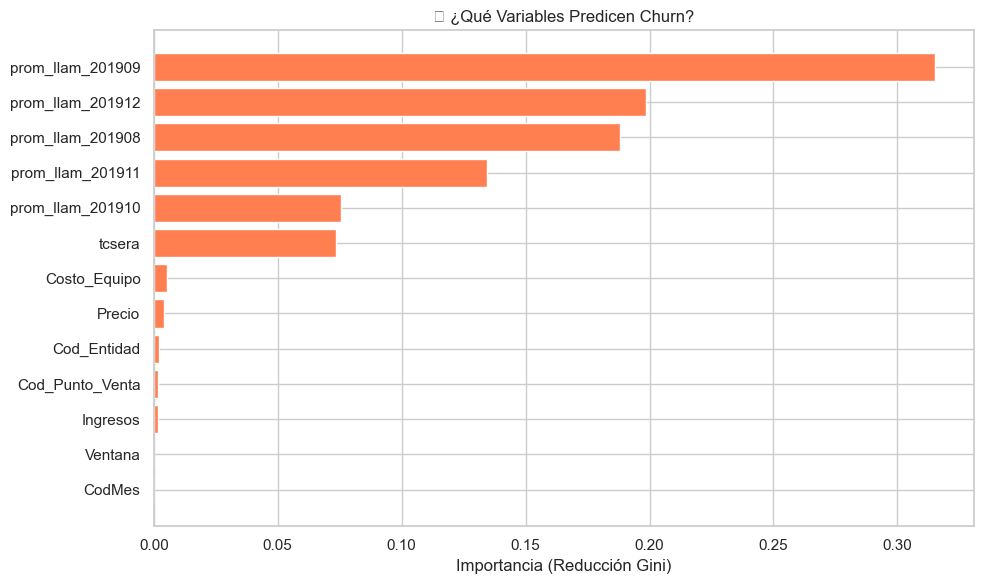

In [14]:
# Feature Importance para Churn
importances = rf_churn.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[indices], color='coral')
plt.yticks(range(len(features)), [features[i] for i in indices])
plt.xlabel('Importancia (Reducción Gini)')
plt.title('🔍 ¿Qué Variables Predicen Churn?')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 🧠 Micro-Desafío: Interpretando Feature Importance

**Pregunta:** Según el gráfico, ¿cuáles son las 3 variables más importantes para predecir churn?

**Reflexión:** ¿Qué acciones de negocio podrías recomendar basándote en estas variables?

---

## 8. Resumen y Siguiente Paso

### 🏆 Resumen de Logros
¡Felicidades! En este notebook has aprendido:

1. **Bagging:** Entrenar múltiples modelos en subconjuntos bootstrap.
2. **Decorrelación:** La aleatoriedad en features reduce la correlación entre árboles.
3. **Reducción de Varianza:** El promedio de muchos árboles es más estable que uno solo.
4. **Feature Importance:** Identificar qué variables son más predictivas.
5. **Paralelización:** Los árboles se entrenan independientemente (escalabilidad).

### ✅ Ventajas de Random Forest
- Robusto a outliers y ruido
- Poco preprocesamiento requerido
- Maneja bien desbalance de clases (con `class_weight`)
- Feature importance interpretable

### ⚠️ Limitaciones
- Menos interpretable que un árbol solo
- Puede ser lento con millones de registros
- No extrapola bien fuera del rango de datos

---

### 👉 Siguiente Paso
Random Forest promedia árboles independientes (paralelos). ¿Y si cada árbol **aprendiera de los errores del anterior**?

**Gradient Boosting:** Entrenar árboles secuencialmente, donde cada uno corrige los errores del anterior.

*En el siguiente notebook veremos XGBoost y LightGBM, los reyes de Kaggle.*